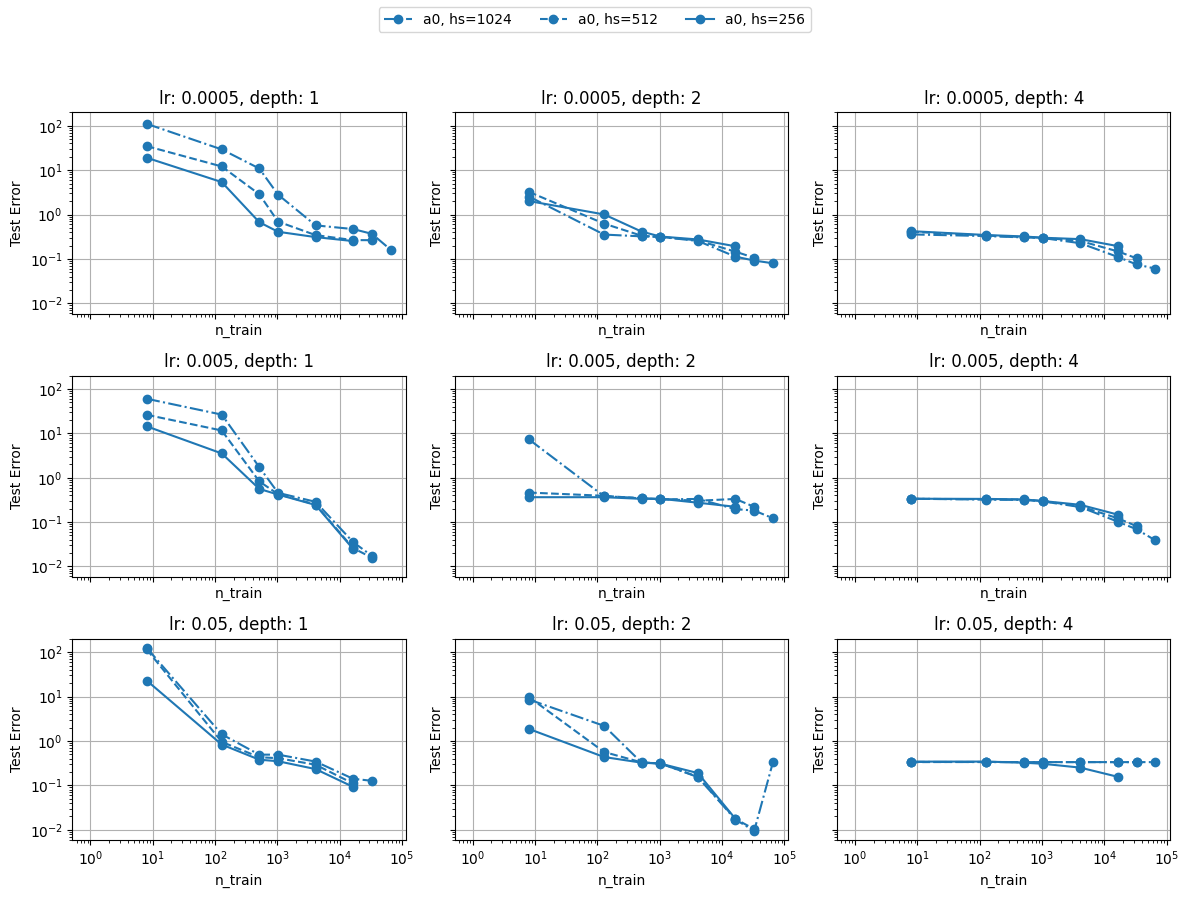

In [7]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_mup_depth_1"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


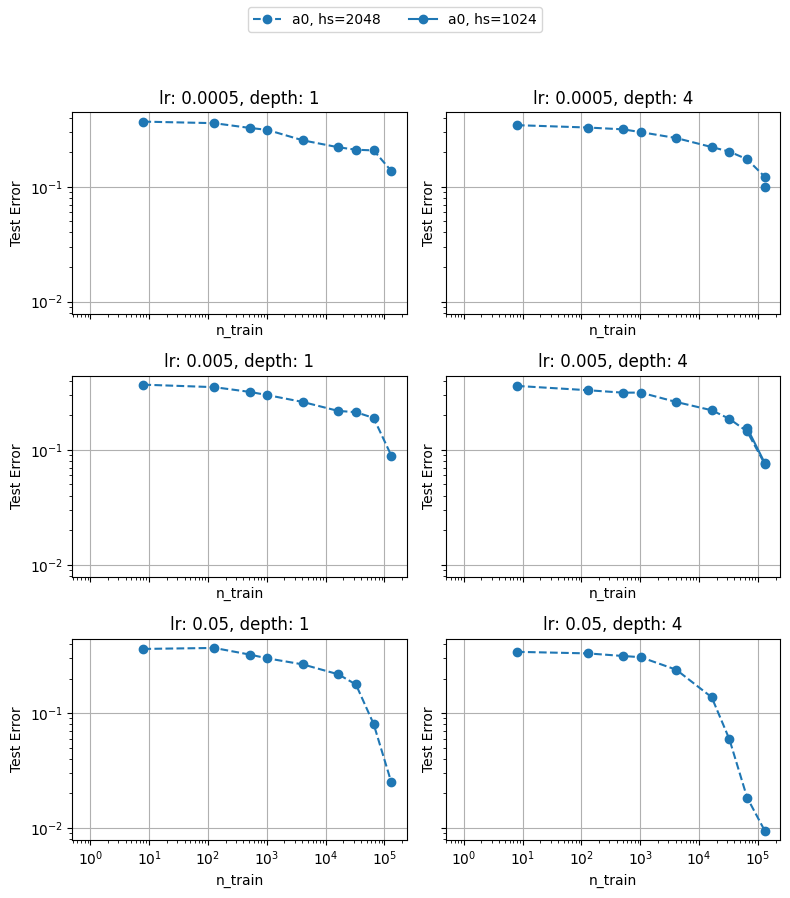

In [6]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_standard_depth_mpi"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


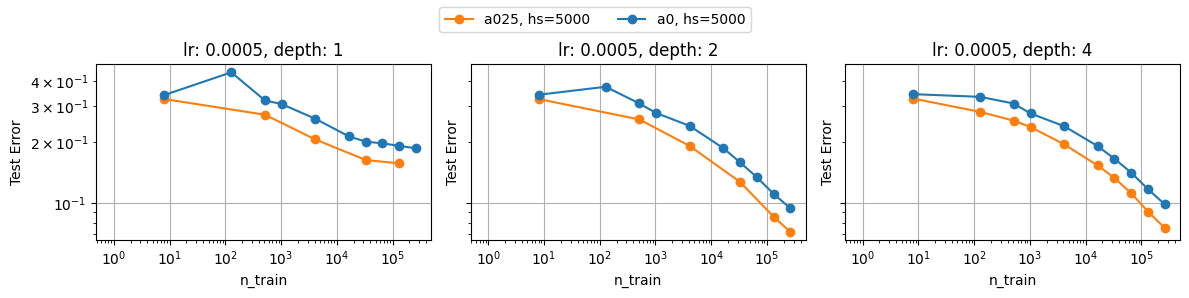

In [8]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_NTKjax_depth_1"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


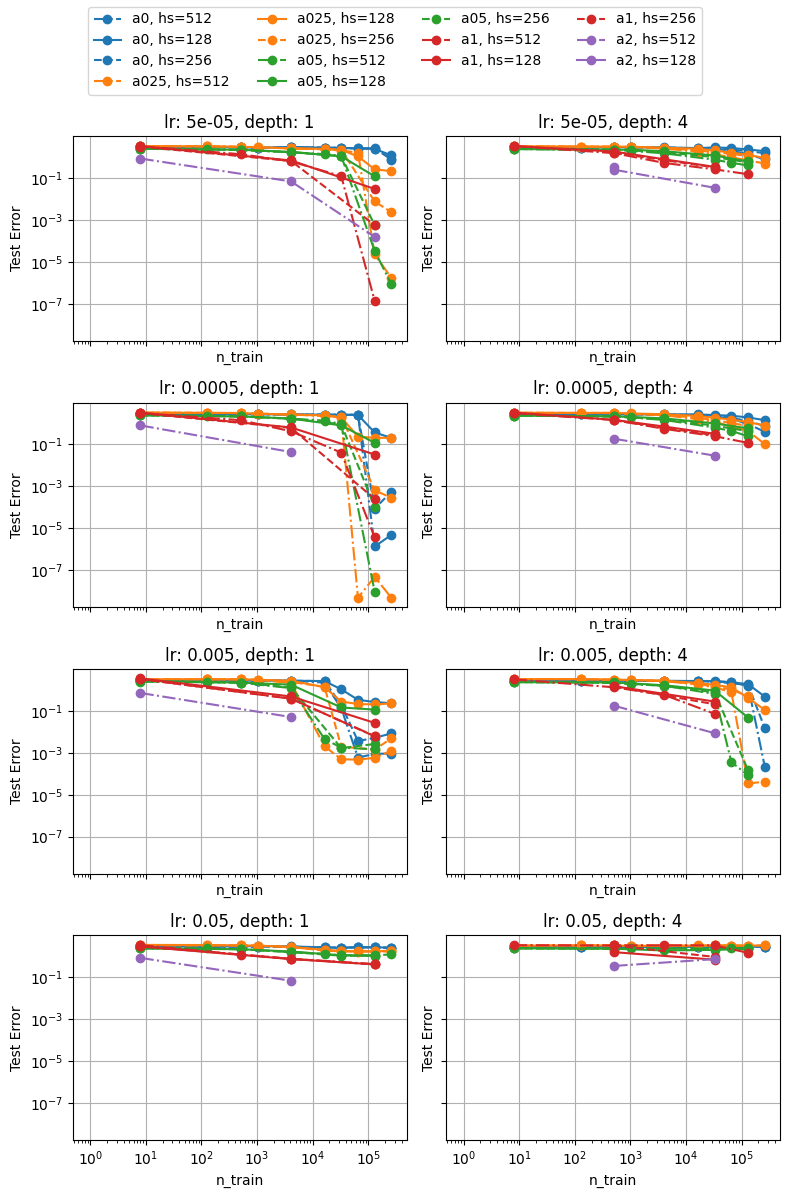

In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


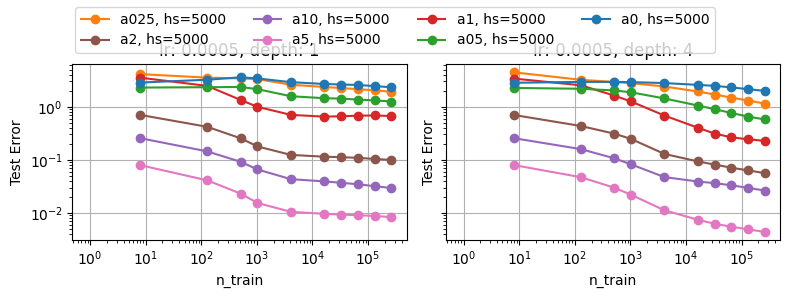

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_NTK_2102_maxiter20k"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


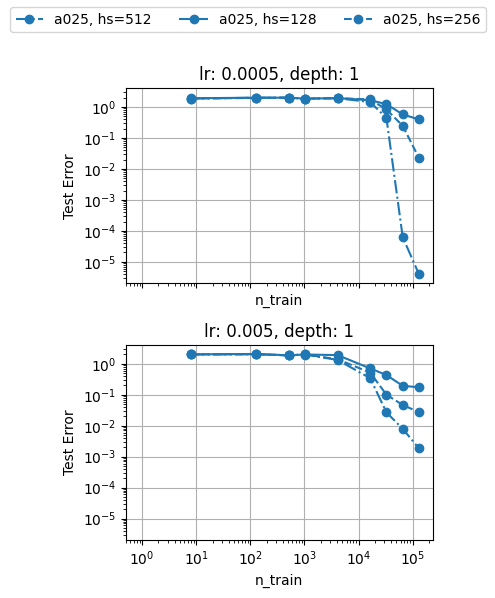

In [3]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d10_hidden256_pytorch_2202_loss"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


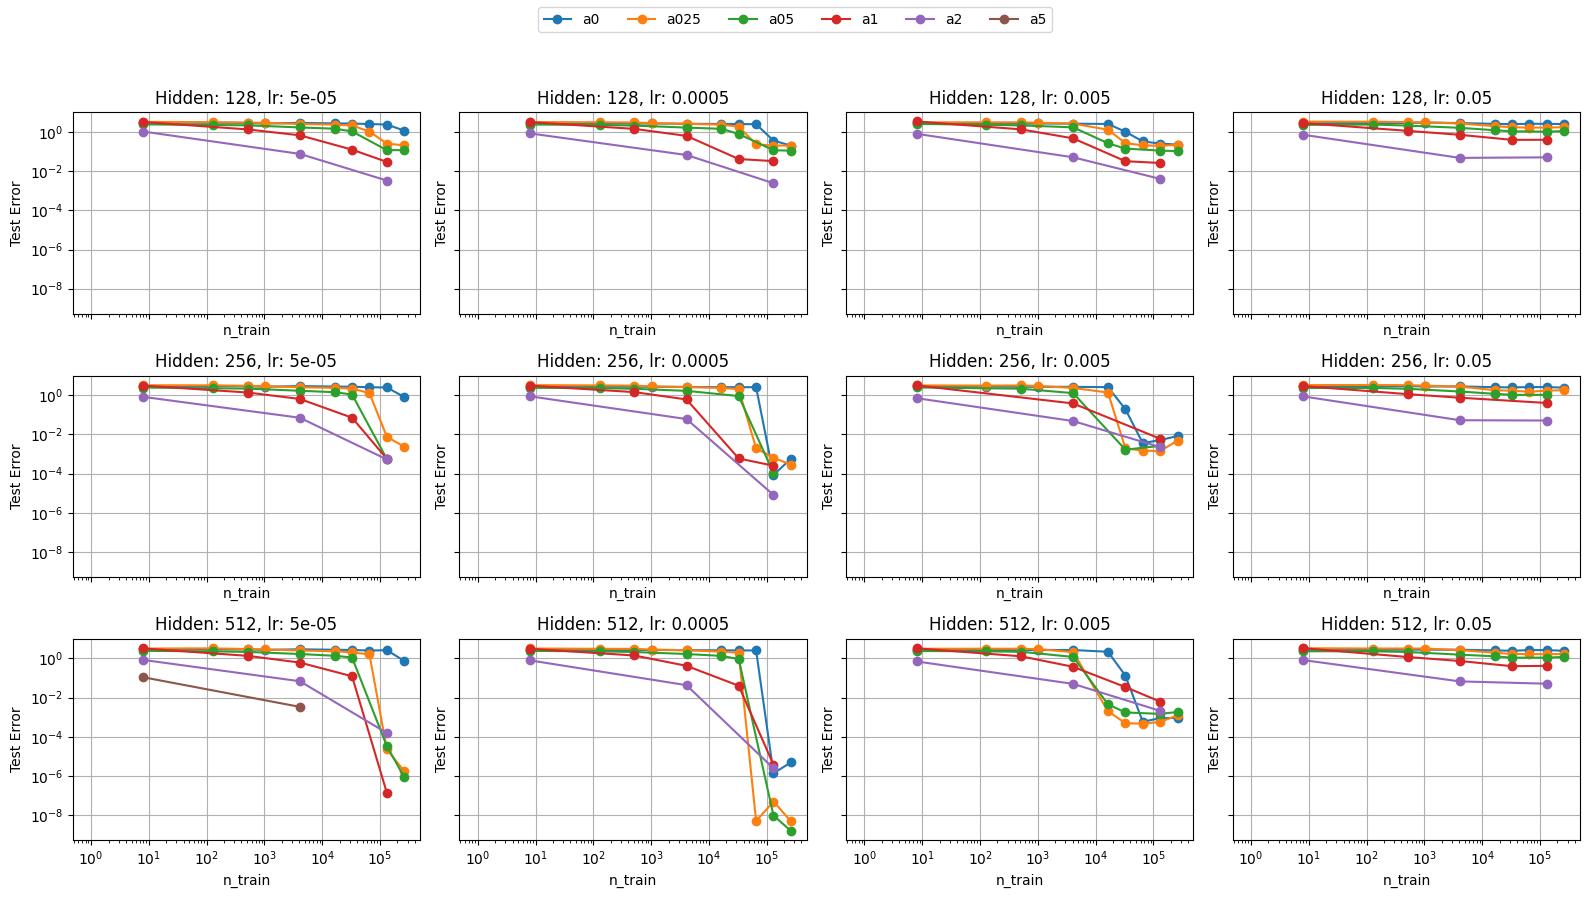

Plot data saved to plot_data.json


In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"
# File path to save the plot data (JSON)
plot_data_file = "plot_data.json"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern "results_*.jsonl".
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS AND COLLECT PLOT DATA =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# This list will hold the plot data.
plot_data = []

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line

            # Save this curve's data.
            curve_data = {
                "hidden_size": hs,
                "learning_rate": lr,
                "dataset": dataset,
                "n_train": x_vals,
                "mean_test_error": y_means,
                "std_test_error": y_stds
            }
            plot_data.append(curve_data)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {plot_data_file}")


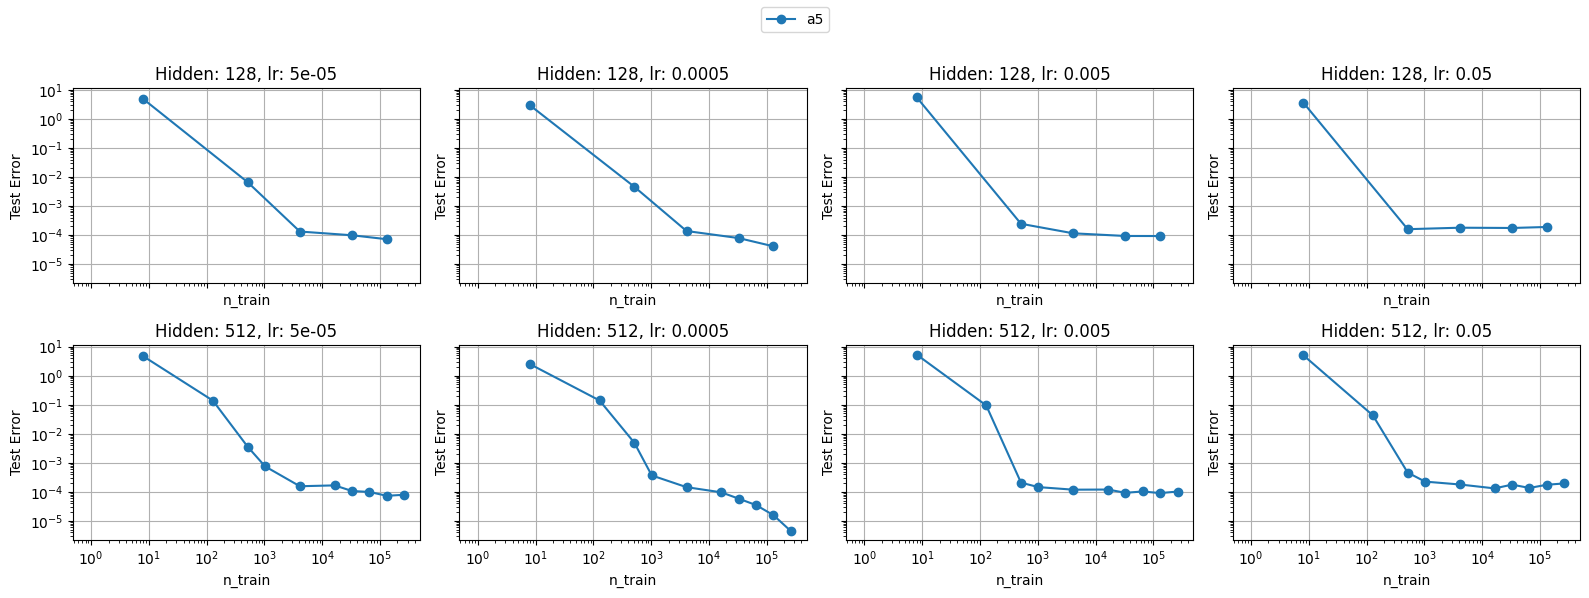

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d10_hidden256_pytorch_2302_biggrid"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


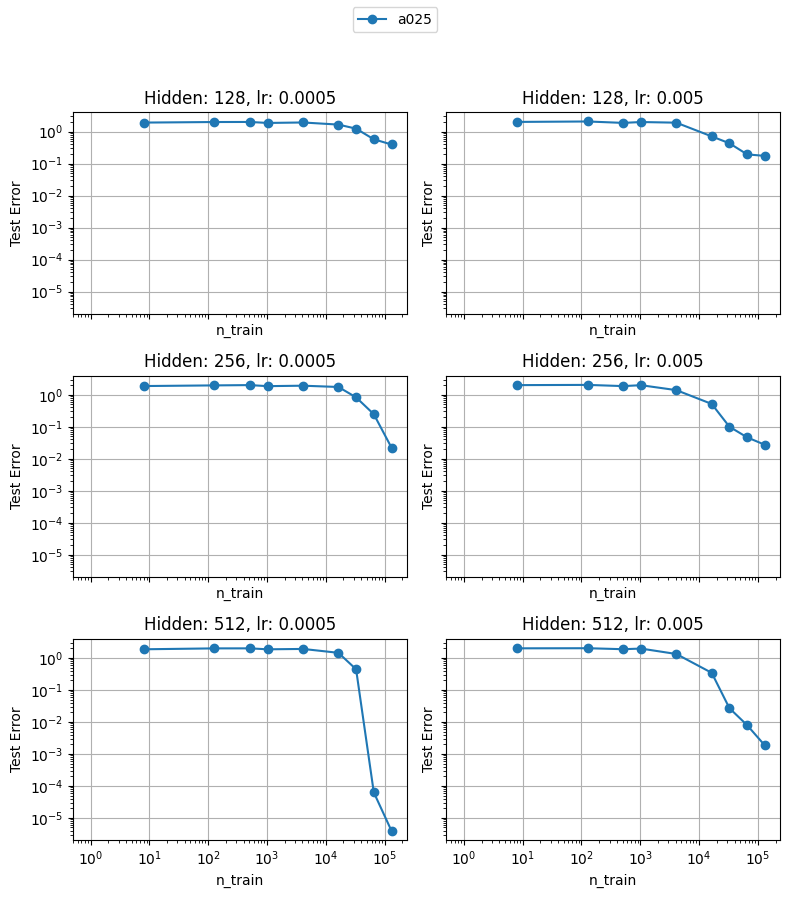

NN learning rates: [5e-05, 0.0005, 0.005, 0.05]
NN hidden sizes: [128, 256, 512]
Common datasets: ['a0', 'a025', 'a05', 'a1', 'a2']


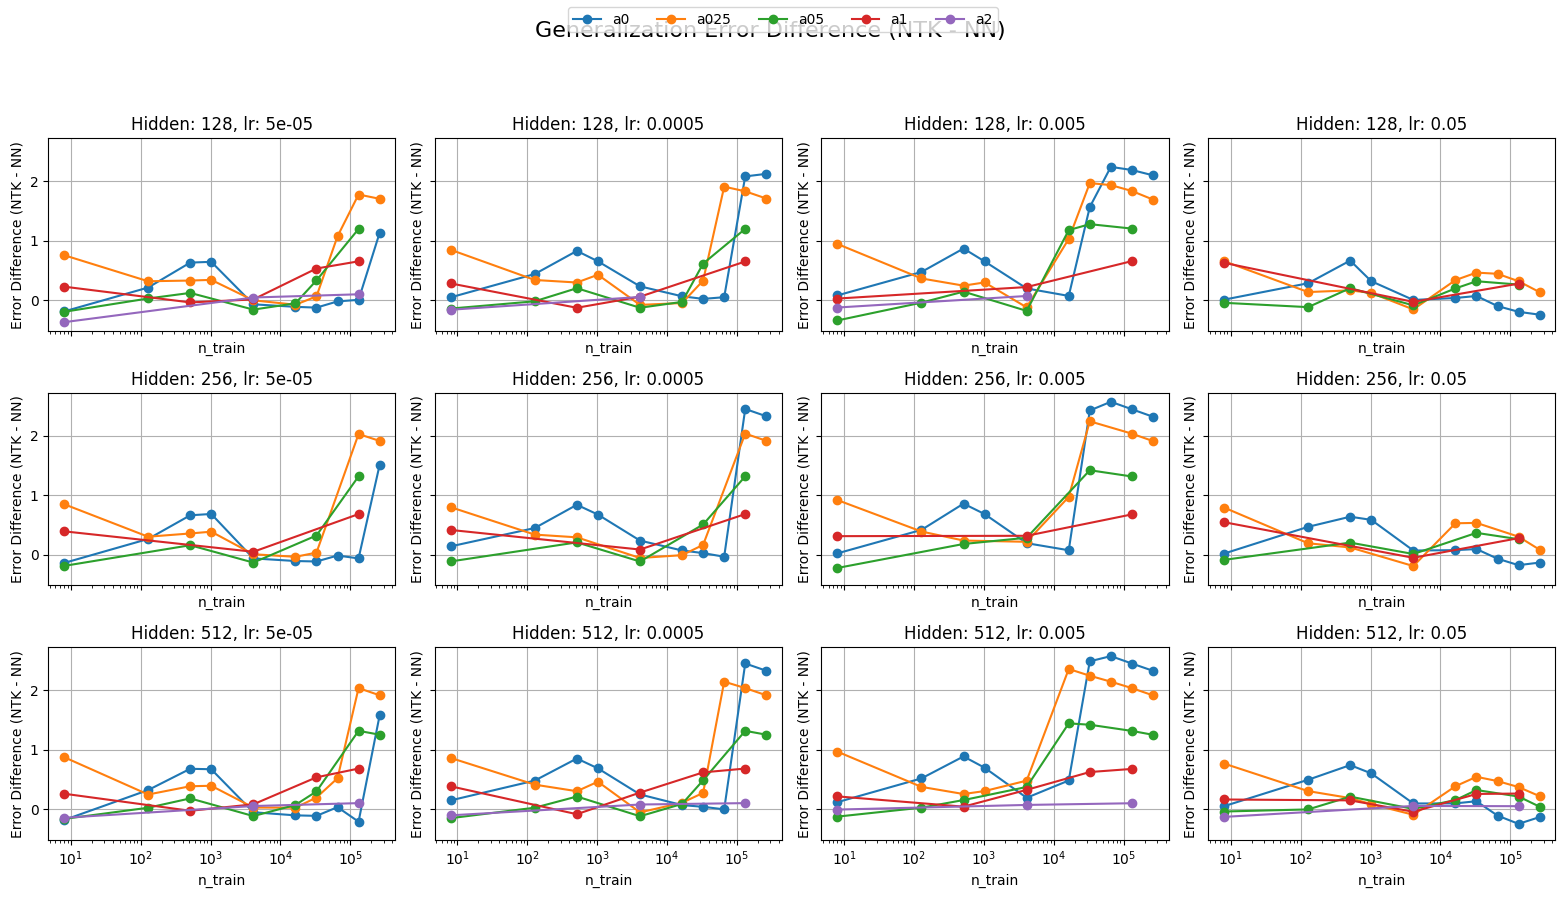

Plot data saved to plot_data.json


In [26]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# NN (baseline) results directory
results_directory_nn = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# NTK results directory (kernels do not vary in lr or width)
results_directory_ntk = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_NTK_2102_maxiter20k"
# Save figure? If not, leave empty.
save_fig_path = ""  # e.g., "my_plot.png"
# Save plot data (x and y values with hyperparameters) as JSON:
save_data_path = "plot_data.json"  # change this if needed

# ======= LOAD RESULTS FUNCTION =======
def load_results(directory, pattern_suffix):
    """
    Load all JSON Lines files in the directory that match the given pattern.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, pattern_suffix)
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# ======= LOAD NN and NTK RESULTS =======
# Use the NN pattern (e.g., "results_*.jsonl")
results_nn = load_results(results_directory_nn, pattern_suffix="results_*.jsonl")
# Use the NTK pattern (e.g., "*_results_*.jsonl")
results_ntk = load_results(results_directory_ntk, pattern_suffix="*_results_*.jsonl")

if not results_nn:
    print("No NN results loaded. Please check the NN directory path.")
if not results_ntk:
    print("No NTK results loaded. Please check the NTK directory path.")

# ======= FILTER FOR DEPTH‑1 NETWORKS =======
results_nn_depth1 = [r for r in results_nn if r.get("depth") == 1]
results_ntk_depth1 = [r for r in results_ntk if r.get("depth") == 1]

# ======= IDENTIFY PARAMETERS FROM NN RESULTS =======
# For NN, we want to plot a grid in terms of hidden size and learning rate.
lr_set_nn = set()
hidden_set_nn = set()
dataset_set_nn = set()
for r in results_nn_depth1:
    try:
        lr_set_nn.add(r["learning_rate"])
        hidden_set_nn.add(r["hidden_size"])
        dataset_set_nn.add(r["dataset_name"])
    except KeyError:
        continue

unique_lr_nn = sorted(lr_set_nn)
unique_hidden_nn = sorted(hidden_set_nn)
# For datasets, use the intersection of NN and NTK datasets.
dataset_set_ntk = set(r["dataset_name"] for r in results_ntk_depth1 if "dataset_name" in r)
common_datasets = sorted(dataset_set_nn.intersection(dataset_set_ntk))

print("NN learning rates:", unique_lr_nn)
print("NN hidden sizes:", unique_hidden_nn)
print("Common datasets:", common_datasets)

# ======= GROUP NN RESULTS =======
# Group by: group_nn[hidden_size][lr][dataset][n_train] = list of test_error values
def group_results_nn(results):
    group = {}
    for r in results:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        if hs not in group:
            group[hs] = {}
        if lr not in group[hs]:
            group[hs][lr] = {}
        if ds not in group[hs][lr]:
            group[hs][lr][ds] = {}
        if n_train not in group[hs][lr][ds]:
            group[hs][lr][ds][n_train] = []
        group[hs][lr][ds][n_train].append(test_error)
    return group

group_nn = group_results_nn(results_nn_depth1)

# ======= GROUP NTK RESULTS (Ignoring lr and width) =======
# Group by: group_ntk[dataset][n_train] = list of test_error values, then average them.
def group_results_ntk(results):
    group = {}
    for r in results:
        try:
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        if ds not in group:
            group[ds] = {}
        if n_train not in group[ds]:
            group[ds][n_train] = []
        group[ds][n_train].append(test_error)
    # Average multiple entries.
    for ds in group:
        for n in group[ds]:
            group[ds][n] = sum(group[ds][n]) / len(group[ds][n])
    return group

group_ntk = group_results_ntk(results_ntk_depth1)

# ======= SET UP COLORS FOR DATASETS =======
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(common_datasets):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= PLOT THE DIFFERENCE (NTK - NN) AND COLLECT PLOT DATA =======
# The grid is defined by NN hidden sizes (rows) and learning rates (columns).
n_rows = len(unique_hidden_nn)
n_cols = len(unique_lr_nn)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# This list will hold our plot data.
plot_data = []

for i, hs in enumerate(unique_hidden_nn):
    for j, lr in enumerate(unique_lr_nn):
        ax = axes[i, j]
        # Check if NN results exist for this configuration.
        if hs not in group_nn or lr not in group_nn[hs]:
            ax.set_visible(False)
            continue
        # For each dataset (e.g. a0, a025, etc.)
        for ds in common_datasets:
            if ds not in group_nn[hs][lr]:
                continue
            nn_data = group_nn[hs][lr][ds]  # { n_train: list of NN test errors }
            # Average NN test errors for each n_train.
            nn_avg = {n: sum(vals)/len(vals) for n, vals in nn_data.items()}
            # For NTK, use the grouped result (already averaged) for this dataset.
            if ds not in group_ntk:
                continue
            ntk_data = group_ntk[ds]  # { n_train: averaged NTK test error }
            # Find common training sizes.
            common_n_train = sorted(set(nn_avg.keys()).intersection(ntk_data.keys()))
            if not common_n_train:
                continue
            x_vals = common_n_train
            diff_vals = [ntk_data[n] - nn_avg[n] for n in x_vals]
            ax.plot(x_vals, diff_vals, marker='o', linestyle='-',
                    color=dataset_colors[ds], label=ds)
            # Save this curve's data
            curve_data = {
                "hidden_size": hs,
                "learning_rate": lr,
                "dataset": ds,
                "n_train": x_vals,
                "error_diff": diff_vals
            }
            plot_data.append(curve_data)
        ax.set_xscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Error Difference (NTK - NN)")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend using proxy artists.
proxy_handles = [Line2D([0], [0], marker='o', color=dataset_colors[ds],
                        linestyle='-') for ds in common_datasets]
fig.legend(proxy_handles, common_datasets, loc="upper center", ncol=len(common_datasets))
fig.suptitle("Generalization Error Difference (NTK - NN)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.93])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(save_data_path, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {save_data_path}")


NN learning rates: [5e-05, 0.0005, 0.005, 0.05]
NN hidden sizes: [128, 256, 512]
Common datasets: ['a0', 'a025', 'a05', 'a1', 'a2', 'a5']


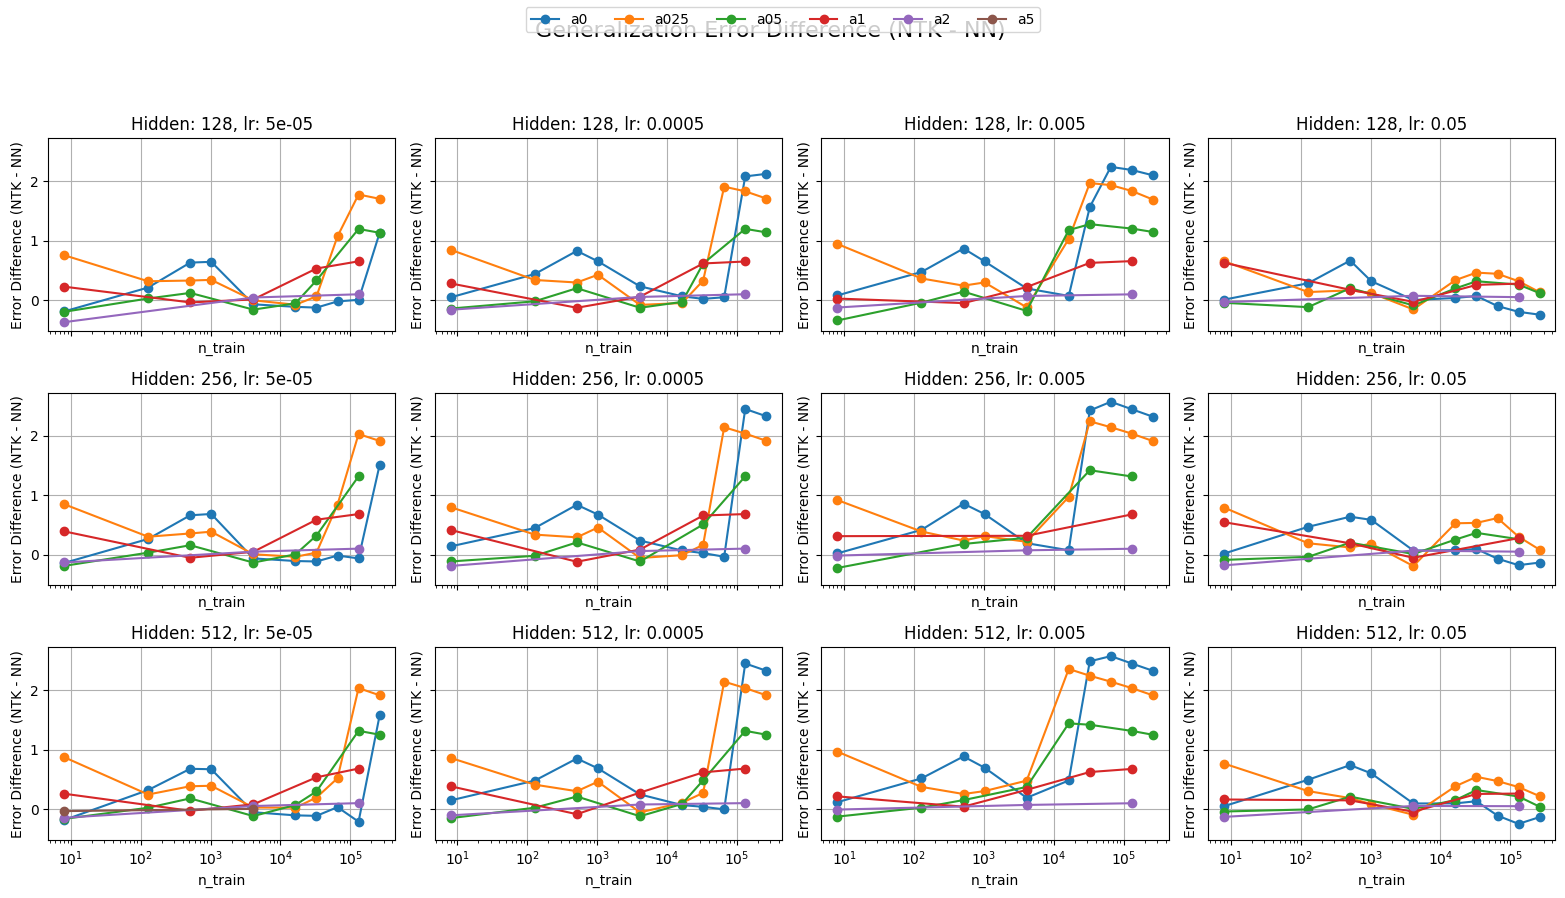

Plot data saved to plot_data.json


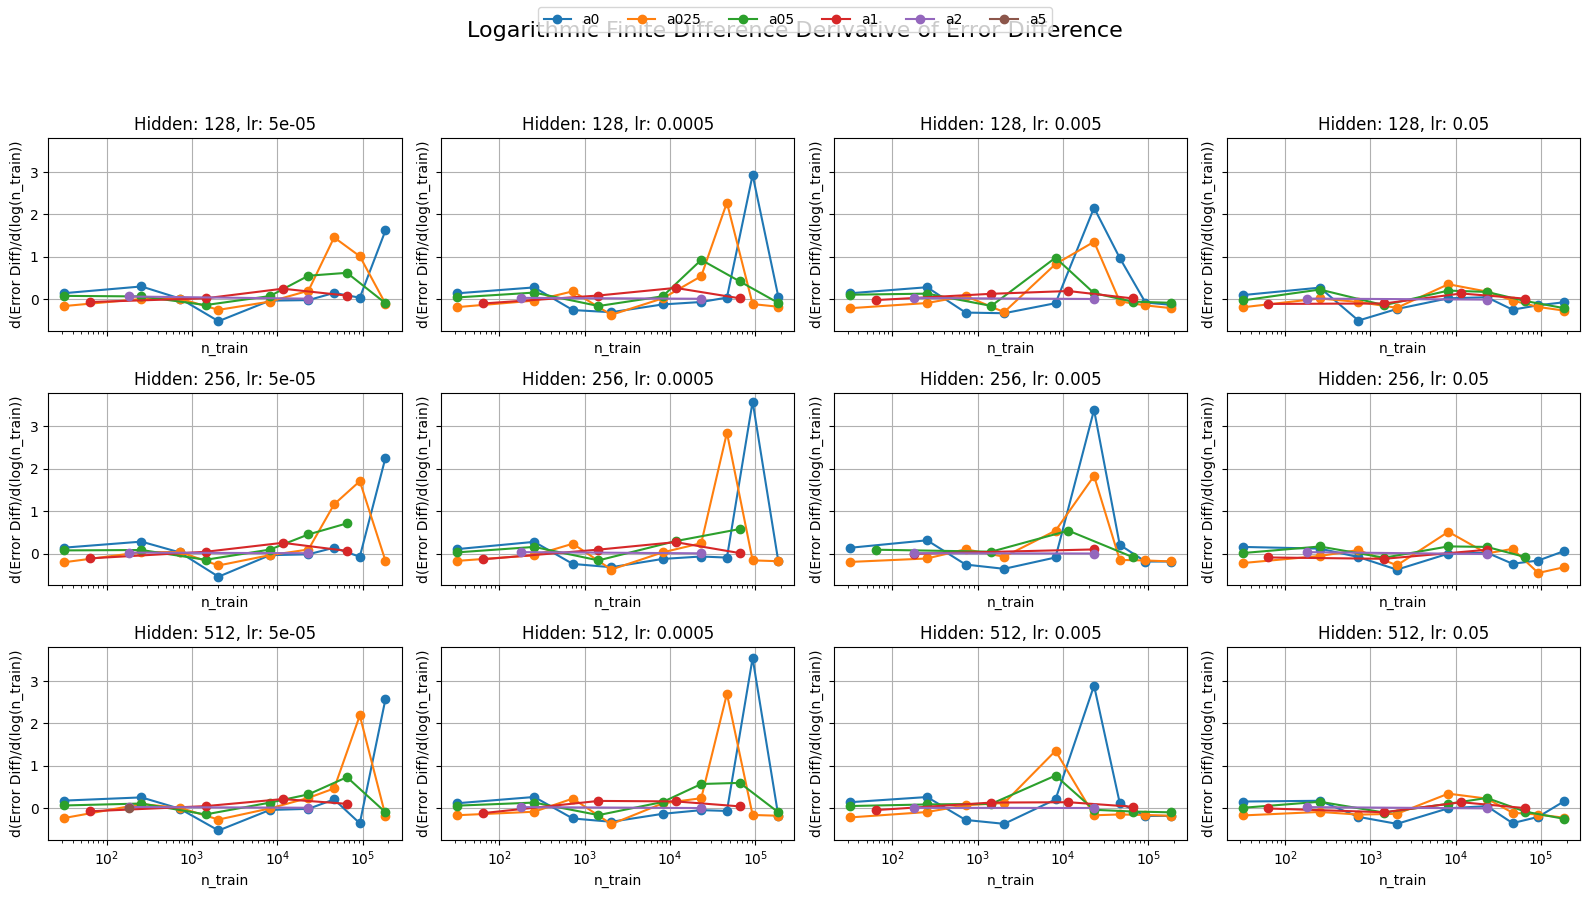

In [3]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# NN (baseline) results directory
results_directory_nn = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# NTK results directory (kernels do not vary in lr or width)
results_directory_ntk = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_NTK_2102_maxiter20k"
# Save figure? If not, leave empty.
save_fig_path = ""  # e.g., "my_plot.png"
# Save plot data (x and y values with hyperparameters) as JSON:
save_data_path = "plot_data.json"  # change this if needed

# ======= LOAD RESULTS FUNCTION =======
def load_results(directory, pattern_suffix):
    """
    Load all JSON Lines files in the directory that match the given pattern.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, pattern_suffix)
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# ======= LOAD NN and NTK RESULTS =======
results_nn = load_results(results_directory_nn, pattern_suffix="results_*.jsonl")
results_ntk = load_results(results_directory_ntk, pattern_suffix="*_results_*.jsonl")

if not results_nn:
    print("No NN results loaded. Please check the NN directory path.")
if not results_ntk:
    print("No NTK results loaded. Please check the NTK directory path.")

# ======= FILTER FOR DEPTH‑1 NETWORKS =======
results_nn_depth1 = [r for r in results_nn if r.get("depth") == 1]
results_ntk_depth1 = [r for r in results_ntk if r.get("depth") == 1]

# ======= IDENTIFY PARAMETERS FROM NN RESULTS =======
lr_set_nn = set()
hidden_set_nn = set()
dataset_set_nn = set()
for r in results_nn_depth1:
    try:
        lr_set_nn.add(r["learning_rate"])
        hidden_set_nn.add(r["hidden_size"])
        dataset_set_nn.add(r["dataset_name"])
    except KeyError:
        continue

unique_lr_nn = sorted(lr_set_nn)
unique_hidden_nn = sorted(hidden_set_nn)
# For datasets, use the intersection of NN and NTK datasets.
dataset_set_ntk = set(r["dataset_name"] for r in results_ntk_depth1 if "dataset_name" in r)
common_datasets = sorted(dataset_set_nn.intersection(dataset_set_ntk))

print("NN learning rates:", unique_lr_nn)
print("NN hidden sizes:", unique_hidden_nn)
print("Common datasets:", common_datasets)

# ======= GROUP NN RESULTS =======
# Group by: group_nn[hidden_size][lr][dataset][n_train] = list of test_error values
def group_results_nn(results):
    group = {}
    for r in results:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        group.setdefault(hs, {}).setdefault(lr, {}).setdefault(ds, {}).setdefault(n_train, []).append(test_error)
    return group

group_nn = group_results_nn(results_nn_depth1)

# ======= GROUP NTK RESULTS (Ignoring lr and width) =======
# Group by: group_ntk[dataset][n_train] = list of test_error values, then average them.
def group_results_ntk(results):
    group = {}
    for r in results:
        try:
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        group.setdefault(ds, {}).setdefault(n_train, []).append(test_error)
    # Average multiple entries.
    for ds in group:
        for n in group[ds]:
            group[ds][n] = sum(group[ds][n]) / len(group[ds][n])
    return group

group_ntk = group_results_ntk(results_ntk_depth1)

# ======= SET UP COLORS FOR DATASETS =======
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {ds: default_colors[i % len(default_colors)] for i, ds in enumerate(common_datasets)}

# ======= PLOT THE DIFFERENCE (NTK - NN) AND COLLECT PLOT DATA =======
n_rows = len(unique_hidden_nn)
n_cols = len(unique_lr_nn)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

plot_data = []

for i, hs in enumerate(unique_hidden_nn):
    for j, lr in enumerate(unique_lr_nn):
        ax = axes[i, j]
        if hs not in group_nn or lr not in group_nn[hs]:
            ax.set_visible(False)
            continue
        for ds in common_datasets:
            if ds not in group_nn[hs][lr]:
                continue
            nn_data = group_nn[hs][lr][ds]
            nn_avg = {n: sum(vals) / len(vals) for n, vals in nn_data.items()}
            if ds not in group_ntk:
                continue
            ntk_data = group_ntk[ds]
            common_n_train = sorted(set(nn_avg.keys()).intersection(ntk_data.keys()))
            if not common_n_train:
                continue
            x_vals = common_n_train
            diff_vals = [ntk_data[n] - nn_avg[n] for n in x_vals]
            ax.plot(x_vals, diff_vals, marker='o', linestyle='-',
                    color=dataset_colors[ds], label=ds)
            curve_data = {
                "hidden_size": hs,
                "learning_rate": lr,
                "dataset": ds,
                "n_train": x_vals,
                "error_diff": diff_vals
            }
            plot_data.append(curve_data)
        ax.set_xscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Error Difference (NTK - NN)")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

proxy_handles = [Line2D([0], [0], marker='o', color=dataset_colors[ds], linestyle='-') for ds in common_datasets]
fig.legend(proxy_handles, common_datasets, loc="upper center", ncol=len(common_datasets))
fig.suptitle("Generalization Error Difference (NTK - NN)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.93])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

with open(save_data_path, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {save_data_path}")

# ======= PLOT THE FIRST DERIVATIVE OF THE CURVES USING LOGARITHMIC FINITE DIFFERENCES =======
fig_deriv, axes_deriv = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes_deriv is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes_deriv = np.array([[axes_deriv]])
elif n_rows == 1:
    axes_deriv = np.array([axes_deriv])
elif n_cols == 1:
    axes_deriv = np.array([[ax] for ax in axes_deriv])

for i, hs in enumerate(unique_hidden_nn):
    for j, lr in enumerate(unique_lr_nn):
        ax = axes_deriv[i, j]
        if hs not in group_nn or lr not in group_nn[hs]:
            ax.set_visible(False)
            continue
        for ds in common_datasets:
            if ds not in group_nn[hs][lr]:
                continue
            nn_data = group_nn[hs][lr][ds]
            nn_avg = {n: sum(vals) / len(vals) for n, vals in nn_data.items()}
            if ds not in group_ntk:
                continue
            ntk_data = group_ntk[ds]
            common_n_train = sorted(set(nn_avg.keys()).intersection(ntk_data.keys()))
            if not common_n_train or len(common_n_train) < 2:
                continue
            x_vals = common_n_train
            diff_vals = [ntk_data[n] - nn_avg[n] for n in x_vals]
            # Compute logarithmic finite difference derivative manually.
            x_arr = np.array(x_vals, dtype=float)
            f_arr = np.array(diff_vals, dtype=float)
            deriv = []
            x_mid = []
            for k in range(len(x_arr) - 1):
                # Compute derivative with respect to log(x)
                dx_log = np.log(x_arr[k+1]) - np.log(x_arr[k])
                df = f_arr[k+1] - f_arr[k]
                deriv.append(df/dx_log)
                # x coordinate as the geometric mean (midpoint in log-space)
                x_mid.append(np.exp((np.log(x_arr[k+1]) + np.log(x_arr[k]))/2))
            ax.plot(x_mid, deriv, marker='o', linestyle='-',
                    color=dataset_colors[ds], label=ds)
        ax.set_xscale("log")
        #ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("d(Error Diff)/d(log(n_train))")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

proxy_handles_deriv = [Line2D([0], [0], marker='o', color=dataset_colors[ds], linestyle='-')
                       for ds in common_datasets]
fig_deriv.legend(proxy_handles_deriv, common_datasets, loc="upper center", ncol=len(common_datasets))
fig_deriv.suptitle("Logarithmic Finite Difference Derivative of Error Difference", fontsize=16)
fig_deriv.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [4]:
#### d10

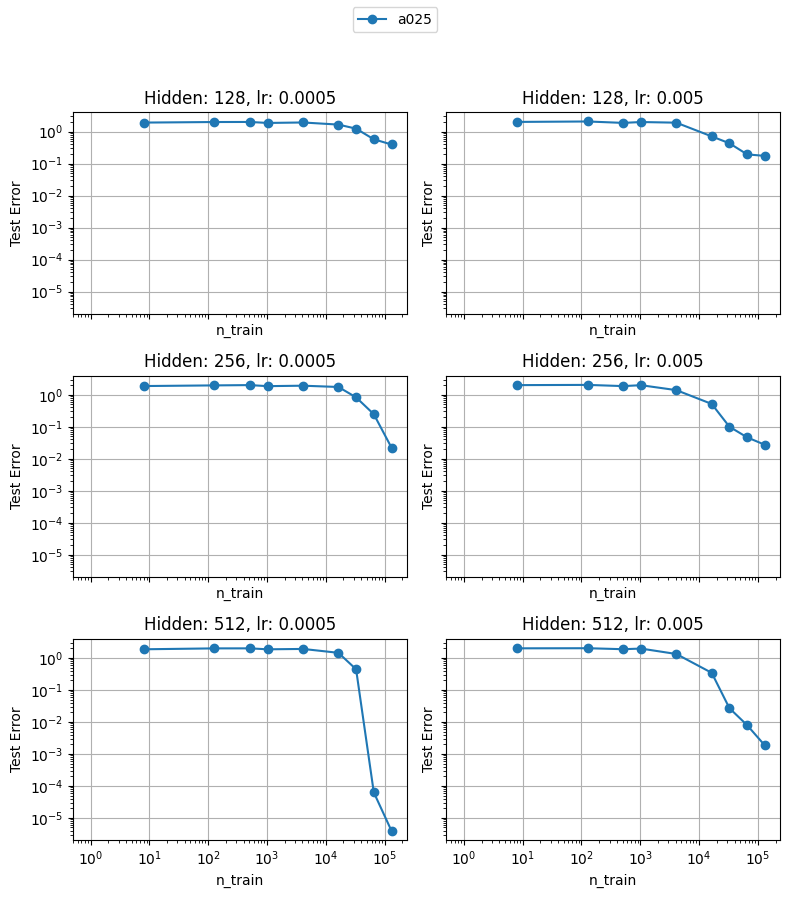

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d10_hidden256_pytorch_2202_loss"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


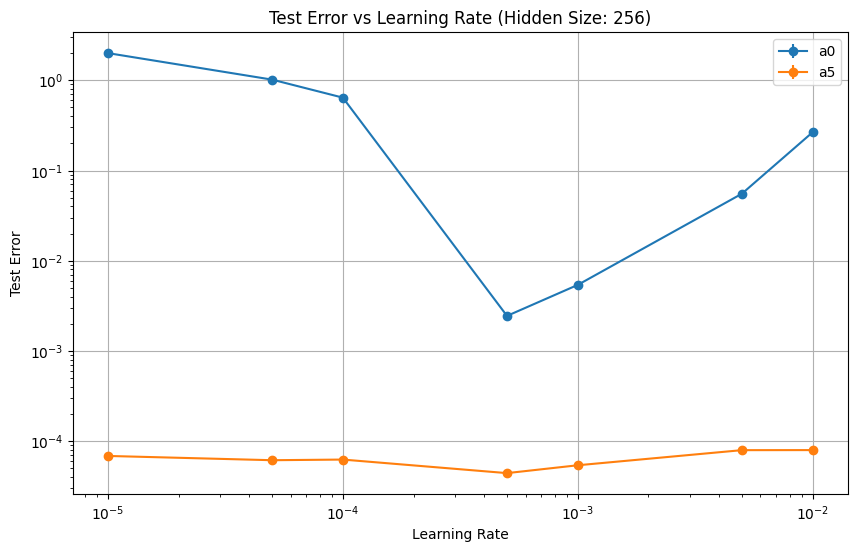

FileNotFoundError: [Errno 2] No such file or directory: ''

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_lr/d10_hidden256_standard_2402_lrgrid_true"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # Set your desired filename here
# File path to save the plot data (JSON)
plot_data_file = ""

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern "results_*.jsonl".
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()
n_train_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
        n_train_set.add(r["n_train"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)
unique_n_train = sorted(n_train_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= PREPARE DATA FOR LEARNING RATE COMPARISON =======
# Structure: lr_data[hidden_size][dataset][learning_rate] = list of test_error values
lr_data = {}

for hs in unique_hidden:
    lr_data[hs] = {}
    for ds in unique_dataset:
        lr_data[hs][ds] = {}
        for lr in unique_lr:
            lr_data[hs][ds][lr] = []

# Populate the data structure
for r in results_depth1:
    try:
        hs = r["hidden_size"]
        ds = r["dataset_name"]
        lr = r["learning_rate"]
        test_error = r["test_error"]
        
        lr_data[hs][ds][lr].append(test_error)
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

# ======= CALCULATE STATISTICS =======
# For each combination, calculate mean and std of test errors
plot_data = []

for hs in unique_hidden:
    for ds in unique_dataset:
        # Prepare data for this hidden size and dataset
        x_vals = []
        y_means = []
        y_stds = []
        
        for lr in unique_lr:
            errors = lr_data[hs][ds][lr]
            if errors:  # Only include if we have data
                x_vals.append(lr)
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
        
        # Save this curve's data
        curve_data = {
            "hidden_size": hs,
            "dataset": ds,
            "learning_rate": x_vals,
            "mean_test_error": y_means,
            "std_test_error": y_stds
        }
        plot_data.append(curve_data)

# ======= CREATE PLOT FOR EACH HIDDEN SIZE =======
for hs in unique_hidden:
    plt.figure(figsize=(10, 6))
    legend_handles = []
    
    for ds in unique_dataset:
        # Find the data for this hidden size and dataset
        ds_data = None
        for data in plot_data:
            if data["hidden_size"] == hs and data["dataset"] == ds:
                ds_data = data
                break
                
        if ds_data and ds_data["learning_rate"]:
            color = dataset_colors[ds]
            x_vals = ds_data["learning_rate"]
            y_means = ds_data["mean_test_error"]
            y_stds = ds_data["std_test_error"]
            
            line = plt.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=ds
            )[0]
            
            legend_handles.append(line)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Test Error")
    plt.title(f"Test Error vs Learning Rate (Hidden Size: {hs})")
    plt.grid(True)
    plt.legend(loc="best")
    
    # Save or show the figure
    if save_fig_path:
        filename = f"{os.path.splitext(save_fig_path)[0]}_hidden{hs}{os.path.splitext(save_fig_path)[1]}"
        plt.savefig(filename)
        print(f"Figure saved to {filename}")
    else:
        plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {plot_data_file}")

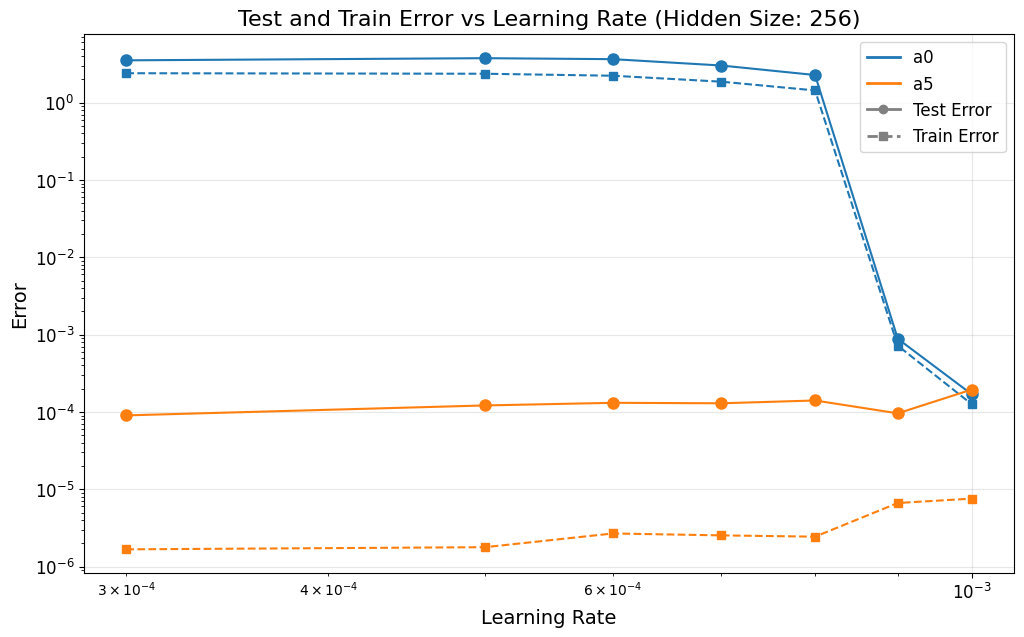

FileNotFoundError: [Errno 2] No such file or directory: ''

In [4]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_lr/d50_hidden256_standard_2402_lrgrid_true_fine"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # Set your desired filename here
# File path to save the plot data (JSON)
plot_data_file = ""

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern "results_*.jsonl".
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()
n_train_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
        n_train_set.add(r["n_train"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)
unique_n_train = sorted(n_train_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= PREPARE DATA FOR LEARNING RATE COMPARISON =======
# Structure: lr_data[hidden_size][dataset][learning_rate]['test'/'train'] = list of error values
lr_data = {}

for hs in unique_hidden:
    lr_data[hs] = {}
    for ds in unique_dataset:
        lr_data[hs][ds] = {}
        for lr in unique_lr:
            lr_data[hs][ds][lr] = {'test': [], 'train': []}

# Populate the data structure
for r in results_depth1:
    try:
        hs = r["hidden_size"]
        ds = r["dataset_name"]
        lr = r["learning_rate"]
        test_error = r["test_error"]
        train_error = r["final_train_error"]
        
        lr_data[hs][ds][lr]['test'].append(test_error)
        lr_data[hs][ds][lr]['train'].append(train_error)
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

# ======= CALCULATE STATISTICS =======
# For each combination, calculate mean and std of test and train errors
plot_data = []

for hs in unique_hidden:
    for ds in unique_dataset:
        # Prepare data for this hidden size and dataset
        x_vals = []
        y_test_means = []
        y_test_stds = []
        y_train_means = []
        y_train_stds = []
        
        for lr in unique_lr:
            test_errors = lr_data[hs][ds][lr]['test']
            train_errors = lr_data[hs][ds][lr]['train']
            
            if test_errors and train_errors:  # Only include if we have both test and train data
                x_vals.append(lr)
                
                # Calculate statistics for test errors
                test_mean = sum(test_errors) / len(test_errors)
                test_std = np.std(test_errors) if len(test_errors) > 1 else 0
                y_test_means.append(test_mean)
                y_test_stds.append(test_std)
                
                # Calculate statistics for train errors
                train_mean = sum(train_errors) / len(train_errors)
                train_std = np.std(train_errors) if len(train_errors) > 1 else 0
                y_train_means.append(train_mean)
                y_train_stds.append(train_std)
        
        # Save this curve's data
        curve_data = {
            "hidden_size": hs,
            "dataset": ds,
            "learning_rate": x_vals,
            "mean_test_error": y_test_means,
            "std_test_error": y_test_stds,
            "mean_train_error": y_train_means,
            "std_train_error": y_train_stds
        }
        plot_data.append(curve_data)

# ======= CREATE PLOT FOR EACH HIDDEN SIZE =======
for hs in unique_hidden:
    plt.figure(figsize=(12, 7))
    legend_handles = []
    
    for ds in unique_dataset:
        # Find the data for this hidden size and dataset
        ds_data = None
        for data in plot_data:
            if data["hidden_size"] == hs and data["dataset"] == ds:
                ds_data = data
                break
                
        if ds_data and ds_data["learning_rate"]:
            color = dataset_colors[ds]
            x_vals = ds_data["learning_rate"]
            
            # Plot test error
            test_line = plt.errorbar(
                x_vals, ds_data["mean_test_error"], yerr=ds_data["std_test_error"],
                linestyle='-', marker='o', color=color, markersize=8,
                label=f"{ds} (Test)"
            )[0]
            
            # Plot train error with the same color but different line style
            train_line = plt.errorbar(
                x_vals, ds_data["mean_train_error"], yerr=ds_data["std_train_error"],
                linestyle='--', marker='s', color=color, markersize=6,
                label=f"{ds} (Train)"
            )[0]
            
            legend_handles.extend([test_line, train_line])
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Learning Rate", fontsize=14)
    plt.ylabel("Error", fontsize=14)
    plt.title(f"Test and Train Error vs Learning Rate (Hidden Size: {hs})", fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Create a more organized legend
    # Group by dataset for cleaner legend
    from matplotlib.lines import Line2D
    custom_lines = []
    custom_labels = []
    
    # First add dataset colors
    for ds in unique_dataset:
        custom_lines.append(Line2D([0], [0], color=dataset_colors[ds], lw=2))
        custom_labels.append(ds)
    
    # Then add line style indicators
    custom_lines.append(Line2D([0], [0], color='gray', lw=2, linestyle='-', marker='o'))
    custom_labels.append('Test Error')
    custom_lines.append(Line2D([0], [0], color='gray', lw=2, linestyle='--', marker='s'))
    custom_labels.append('Train Error')
    
    plt.legend(custom_lines, custom_labels, loc="best", fontsize=12)
    
    # Improve tick labels
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Set better y-limits to focus on the data
    plt.ylim(bottom=min([min(data["mean_train_error"] + data["mean_test_error"]) 
                        for data in plot_data if data["hidden_size"] == hs]) / 2)
    
    # Save or show the figure
    if save_fig_path:
        filename = f"{os.path.splitext(save_fig_path)[0]}_hidden{hs}{os.path.splitext(save_fig_path)[1]}"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {filename}")
    else:
        plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {plot_data_file}")